In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_json("./data/Appliances.json", lines=True)


In [ ]:
##### 1. Data Cleaning #####
from pydantic import BaseModel
from openai import OpenAI
system_prompt = """
Analyze the following product review and provide a summary of the key points:
- Does the review mention any specific problems or defects with the product?
- Does the review mention any positive attributes regarding the product's durability or reliability?
- Does the review indicate that the product meets or exceeds the user's expectations?
- Would the reviewer recommend this product to others?
"""

client = OpenAI(api_key=OPENAI_API_KEY)
class ProductAnalysis(BaseModel):
    defects: bool
    durability: bool
    expectations: bool
    recommend: bool

def analyze_review(review: str) -> ProductAnalysis:
    completion = client.beta.chat.completions.parse(
        model="gpt-4o-mini-2024-07-18",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": review},
        ],
        response_format=ProductAnalysis,
    )
    return completion



In [ ]:
#### Pick out two product reviews to analyze ####

In [5]:
df_product = df[df['asin'] == 'B0016HT444'].reset_index(drop=True)
df_product = df[df['asin'] == 'B0053F80JA'].reset_index(drop=True)

In [6]:
df_product = df_product.dropna(subset=['reviewText']).reset_index(drop=True)

In [7]:
df_product['observation'] = df_product['reviewText'].apply(analyze_review)

KeyboardInterrupt: 

In [89]:
import json
df_product['observation_json'] = (df_product['observation'].apply(lambda x: json.loads(x.choices[0].message.content)).values)

In [ ]:
## make list of dicts a DataFrame
df_observation = pd.json_normalize(df_product['observation_json'])

In [ ]:
df_observation

In [101]:
df_product = pd.concat([df_product, df_observation], axis=1)

In [102]:
df_product.to_csv('data/good_product_data.csv', index=False)

In [ ]:
df_product.groupby('overall')[['defects', 'durability', 'expectations', 'recommend']].mean()

In [8]:
products_good = pd.read_csv('data/good_product_data.csv')
products_good['good'] = True
products_bad = pd.read_csv('data/bad_product_data.csv') 
products_bad['good'] = False

In [9]:
products_all = pd.concat([products_good,products_bad],axis=0)[['defects', 'durability', 'expectations', 'recommend','overall','good']].reset_index(drop=True)


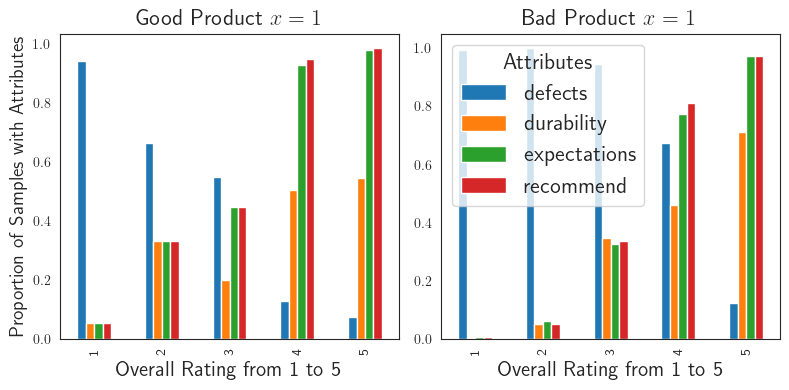

In [12]:
import seaborn as sns
import matplotlib

#### Product Analysis Plot ####
matplotlib.rcParams.update({'text.usetex': True})
sns.set_style("white")
fix,axs = plt.subplots(1, 2, figsize=(8, 4))
products_good.groupby('overall')[['defects', 'durability', 'expectations', 'recommend']].mean().plot(kind='bar', ax=axs[0])
### error bars
# axs[0].legend(title='Attributes',fontsize=15)
## turn off legend
axs[0].set_title('Good Product $x=1$',fontsize=16)
axs[0].legend().set_visible(False)
products_bad.groupby('overall')[['defects', 'durability', 'expectations', 'recommend']].mean().plot(kind='bar', ax=axs[1])
axs[1].set_title('Bad Product $x=1$',fontsize=16)

axs[0].set_ylabel("Proportion of Samples with Attributes",fontsize=14)
axs[0].set_xlabel("Overall Rating from 1 to 5",fontsize=15)
axs[1].legend(title='Attributes',fontsize=16,title_fontsize=16, loc='upper left')

axs[1].set_xlabel("Overall Rating from 1 to 5",fontsize=15)
plt.tight_layout()
plt.savefig("plots/analysis_plot_product.pgf")
plt.show()

In [ ]:
products_all.groupby(['good','overall']).mean().plot(kind='bar', figsize=(12, 6))

In [15]:
products = df.groupby('asin').agg({"overall":"mean", "reviewText":"count"}).sort_values(by="reviewText", ascending=False)